<a href="https://colab.research.google.com/github/dzisandy/Deep-Learning/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import warnings
warnings.simplefilter("ignore")

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL.Image import open
from tqdm import trange
from IPython import display

In [2]:
'''http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html , downloaded from Google Drive, using Google Drive downloader'''
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='0B7EVK8r0v71pZjFTYXZWM3FlRnM',dest_path='./data',unzip=True)


Unzipping...Done.


In [0]:
'''dataset generation'''
class CelebDataset(Dataset):
    def __init__(self, train = None, transform=None):
        super(Dataset, self).__init__()
        
        if train:
            self.img = sorted(os.listdir(path='./img_align_celeba'))[:162770]
        else:
            self.img = sorted(os.listdir(path='./img_align_celeba'))[162771:]
        self.transform = transform

    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, idx):
        img = open(os.path.join('./img_align_celeba',self.img[idx]))        
        if self.transform:
            img = self.transform(img)
        return img

In [0]:
'''here we set the data size (now 128x128), and transformation to do it'''
img_size = 64
transform = transforms.Compose([transforms.CenterCrop((178,178)),
                                transforms.Resize((img_size,img_size)),
                                transforms.ToTensor()
                               ])

In [0]:
'''validation and train Dataloaders, batchsizes to be adjusted'''
t_batch_size = 64
v_batch_size = 5

train_dataset = CelebDataset(transform = transform, train = True)
train_dataloader = DataLoader(train_dataset,batch_size = t_batch_size, shuffle=True)

val_dataset = CelebDataset(transform = transform)
val_dataloader = DataLoader(train_dataset, batch_size = v_batch_size, shuffle=False)



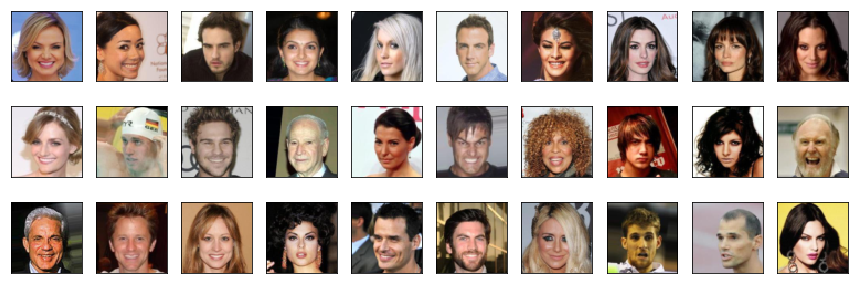

In [6]:
'''data visualization'''
for item in train_dataloader:
    plt.figure(figsize = (15,5))
    for i in range(30):
        plt.subplot(3,10,i+1)
        plt.imshow(transforms.ToPILImage()(item[i]))
        plt.xticks(())
        plt.yticks(())
    plt.show()
    break


In [0]:
import torch.nn as nn
import torch.optim as optim
import torch


In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        '''https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch'''
        def initialization(layer):
            if type(layer) == nn.Linear:
                torch.nn.init.xavier_uniform(layer.weight)
                layer.bias.data.fill_(0.)


        
        self.encoder = nn.Sequential()
        self.encoder.add_module('conv1', nn.Conv2d(3, 128, 5, 2, 2))
        self.encoder.add_module('bn1', nn.BatchNorm2d(128))
        self.encoder.add_module('relu1', nn.LeakyReLU(0.2))
        
        self.encoder.add_module('conv2', nn.Conv2d(128, 256, 5, 2, 2))
        self.encoder.add_module('bn2', nn.BatchNorm2d(256))
        self.encoder.add_module('relu2', nn.LeakyReLU(0.2))
        
        self.encoder.add_module('conv3', nn.Conv2d(256, 512, 5, 2, 2))
        self.encoder.add_module('bn3', nn.BatchNorm2d(512))
        self.encoder.add_module('relu3', nn.LeakyReLU(0.2))
        
        self.encoder.add_module('conv4', nn.Conv2d(512, 1024, 5, 2, 2))
        self.encoder.add_module('bn4', nn.BatchNorm2d(1024))
        self.encoder.add_module('relu4', nn.LeakyReLU(0.2))
        
        self.encoder.add_module('fc1',nn.Linear(128*8*4*4, 64))
        
        self.encoder.apply(initialization)
        
        
        self.decoder = nn.Sequential()
        self.decoder.add_module('fc1', nn.Linear(64, 128*8*4*4))
        self.decoder.add_module('bn1', nn.BatchNorm2d(128*8*4*4))
        self.decoder.add_module('relu1', nn.LeakyReLU(0.2))
        
        
        self.decoder.add_module('conv1', nn.ConvTranspose2d(128*4, 128*2, 4,2,1))
        self.decoder.add_module('bn1', nn.BatchNorm2d(128*2))
        self.decoder.add_module('relu1', nn.LeakyReLU(0.2))
        
        self.decoder.add_module('conv2', nn.ConvTranspose2d(128*2, 128, 4,2,1))
        self.decoder.add_module('bn2', nn.BatchNorm2d(128))
        self.decoder.add_module('relu2', nn.LeakyReLU(0.2))
        
        self.decoder.add_module('conv3', nn.ConvTranspose2d(128, 3, 4,2,1))
        self.decoder.add_module('sigmoid', nn.Sigmoid())
        self.decoder.apply(initialization)

        
        
    def forward(self, x):        
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        return reconstruction, latent_code

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        def initialization(layer):
            if type(layer) == nn.Linear:
                torch.nn.init.xavier_uniform(layer.weight)
                layer.bias.data.fill_(0.)

        self.latent_variable_size = 64
        self.hid_size = 512

        self.linear = nn.Sequential()
        
        self.linear.add_module('fc1', nn.Linear(64,512))
        self.linear.add_module('relu1', nn.ReLU())
        
        self.linear.add_module('fc2', nn.Linear(512,512))
        self.linear.add_module('relu2', nn.ReLU())
        
        self.linear.add_module('fc3', nn.Linear(512,512))
        self.linear.add_module('relu3', nn.ReLU())
        
        self.linear.add_module('fc4', nn.Linear(512,512))
        self.linear.add_module('relu4', nn.ReLU())
        
        self.linear.add_module('fc5', nn.Linear(512,1))
        
        self.linear.apply(initialization)

    def forward(self, z):
        return self.linear(z)

In [0]:
criterion = torch.nn.MSELoss()

autoencoder = VAE().cuda()
discriminator = Discriminator().cuda()

optimizer = optim.Adam(autoencoder.parameters())

In [26]:
'''till this part everything is ok, and no need to rewrite (NOT DEBUGGED)'''

'till this part everything is ok, and no need to rewrite (NOT DEBUGGED)'

In [0]:
'''train function to be rewritten'''
def loss_cuda(model, criterion, X):
    X = Variable(X).cuda()
    encode, _ = model(X)
    return criterion(encode, X)
  
def train(model, n_epoch, criterion, optimizer, train_loader, val_loader, img_size):
    train_loss = []
    image_progress = []
    for epoch in trange(n_epoch):
        model.train()
        for X in train_loader:
            loss = loss_cuda(model, criterion, X[0])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.data.cpu().numpy())
        model.eval()
        for X in val_loader:
            encode, _ = model(Variable(X[0]).cuda())
        if epoch in [6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96]:
            image_progress.append(encode[0])
        display.clear_output(wait = True)
        
        #reconstruction
        plt.figure(figsize = (10,5))
        plt.subplot(1,2,1)
        plt.imshow(X[0].cpu().numpy().reshape((img_size, img_size, 3)))
        plt.title('Original image')
        plt.subplot(1,2,2)
        plt.imshow(encode.data.cpu().numpy().reshape((img_size, img_size, 3)))
        plt.title('Encoded image')
        plt.show()
        
        #loss decay
        plt.figure(figsize = (10,5))
        plt.plot(train_loss)
        plt.title('Train loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.show()
    return image_progress

In [0]:
image_progress = train(autoencoder, 100, criterion, optimizer, train_loader, val_loader, img_size)